<a href="https://colab.research.google.com/github/mugheesahmad/EuroSat-PyTorch/blob/master/EuroSat_Pytorch_with_Albumenation_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing** **Libraries**

In [0]:
#Importing Libraries

import torch
from torchvision import models
import torchvision
import torch.nn as nn
import numpy as np
import random
from IPython.display import clear_output
import time
import os.path
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage import io

In [0]:
EuroSat_Type = 'RGB'    # use 'RGB' or 'ALL' for type of Eurosat Dataset. Just change in this line. Rest of the code is managed for both type
lr = 0.01               # learn_rate
milestones = [50,75,90] # multistep scheduler
epochs = 100            # no of epochs

In [0]:
def iloader(path):
    image = np.asarray((io.imread(path))/32000,dtype='float32')
    augmentation = strong_tiff_aug(p=0.9)
    imgc = augmentation(image=image)['image']
    return imgc.transpose(2,0,1)
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [0]:
def Load_data():
    if EuroSat_Type == 'RGB':
      data = torchvision.datasets.DatasetFolder(root=root,loader = iloader, transform=None, extensions = 'jpg')
    elif EuroSat_Type == 'ALL':
      data = torchvision.datasets.DatasetFolder(root=root,loader = iloader, transform=None, extensions = 'tif')
    train_set, val_set = train_test_split(data, test_size=0.2, stratify=data.targets)
    #print(np.unique(train_set, return_counts=True))  #uncomment for class IDs
    #print(np.unique(val_set, return_counts=True))    #uncomment for class IDs
      
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=3, drop_last = True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=0, drop_last = True)
    #test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=0, drop_last = True)
    return train_loader, val_loader #,test_loader

**Functions for Augmentation**

In [0]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose)

def strong_tiff_aug(p=.5):
    return Compose([
        # albumentations supports uint8 and float32 inputs. For the latter, all
        # values must lie in the range [0.0, 1.0]. To apply augmentations, we
        # first use a `ToFloat()` transformation, which will inspect the data
        # type of the input image and convert the image to a float32 ndarray where
        # all values lie in the required range [0.0, 1.0].
        #ToFloat(),
        
        # Alternatively, you can specify the maximum possible value for your input
        # and all values will be divided by it instead of using a predefined value
        # for a specific data type.       
        # ToFloat(max_value=65535.0),
        
        # Then we will apply augmentations
        RandomRotate90(),
        Flip(),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
        ], p=0.2),        
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=0.1, val_shift_limit=0.1, p=0.3),
        
        # You can convert the augmented image back to its original
        # data type by using `FromFloat`.
        # FromFloat(dtype='uint16'),

        # As in `ToFloat` you can specify a `max_value` argument and all input values
        # will be multiplied by it.
        # FromFloat(dtype='uint16', max_value=65535.0),

    ], p=p)

In [0]:
def Load_model():
    model_ft = models.resnet50()#pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 10)
    if EuroSat_Type == 'RGB':
      inBands = 3
    elif EuroSat_Type == 'ALL':
      inBands = 13
    model_ft.conv1 = nn.Conv2d(inBands, 64, kernel_size=7, stride=2, padding = 3, bias = False)
    print('Model Loaded')
    return model_ft

In [0]:
def accuracy(gt_S,pred_S):       
    _, alp = torch.max(torch.from_numpy(pred_S), 1)
    return accuracy_score(gt_S,np.asarray(alp))#np.mean(F1score)

In [0]:
def validation(model, test_,):
    model.eval()
    #tot_acc=[]
    test_iter=0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            output = model(data)
            _, pred = torch.max(output, 1)
            pred = output.data.cpu().numpy()
            gt = target.data.cpu().numpy()
            if test_iter==0:
                all_pred=pred
                all_gt=gt
            else:
                all_pred=np.vstack((all_pred,pred))
                all_gt  =np.vstack((all_gt,gt))

            test_iter=test_iter+1
        acc=accuracy(all_gt.reshape(all_gt.shape[0] * all_gt.shape[1]),all_pred)
        model.train()
        return acc#,cm

In [0]:
def train(net, train_, val_, criterion, optimizer, epochs=None, scheduler=None, weights=None, save_epoch = 10):
    losses=[]; acc=[]; mean_losses=[]; val_acc=[]
    iter_ = t0 =0
    for e in range(1, epochs + 1):
        net.train()
        for batch_idx, (data, target) in enumerate(train_):
            data, target = Variable(data.cuda()), Variable(target.cuda()),
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            losses = np.append(losses,loss.item())
            mean_losses = np.append(mean_losses, np.mean(losses[max(0,iter_-100):iter_]))
            if iter_ % 600 == 0: #printing after 600 epochs
                clear_output()
                print('Iteration Number',iter_,'{} seconds'.format(time.time() - t0))
                t0 = time.time()
                pred = output.data.cpu().numpy()#[0]
                pred=sigmoid(pred)
                gt = target.data.cpu().numpy()#[0]
                acc = np.append(acc,accuracy(gt,pred))
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}\tLearning Rate:{}'.format(
                    e, epochs, batch_idx, len(train_),
                    100. * batch_idx / len(train_), loss.item(), acc[-1],optimizer.param_groups[0]['lr']))
                plt.plot(mean_losses) and plt.show()
                val_acc = np.append(val_acc,validation(net, val_))
                print('validation accuracy : {}'.format(val_acc[-1]))
                plt.plot( range(len(acc)) ,acc,'b',label = 'training')
                plt.plot( range(len(val_acc)), val_acc,'r--',label = 'validation')
                plt.legend() and plt.show()
                #print(mylabels[np.where(gt[1,:])[0]])
            iter_ += 1
            
            del(data, target, loss)
        if scheduler is not None:
           scheduler.step(val_acc[-1])
        if e % save_epoch == 0:
            
            torch.save(net.state_dict(), '.\Eurosat{}'.format(e))
    return net

Downloading and unzipping EuroSAT database : https://arxiv.org/abs/1709.00029
(2500-3000) x 10 x 64 x 64 px RGB Sentinel 2 images.

This below mentioned code block for downloading the dataset is taken from the code by [RomainHugues](https://https://github.com/RomainHugues/EuroSat/blob/master/EuroSAT.ipynb)


# Use 'RGB' or 'ALL' for type of Eurosat Dataset. Read the details about both [here ](https://https://github.com/phelber/EuroSAT)

In [0]:
if EuroSat_Type == 'RGB':
  data_folder = '/content/sample_data/'
  #root = os.path.join(data_folder, '2750/')
  root = '2750/'
  download_ON = os.path.exists(root)

  if not download_ON:
    # This can be long...
    #os.chdir(data_folder)
    os.system('wget http://madm.dfki.de/files/sentinel/EuroSAT.zip') #Just RGB Bands
    !unzip EuroSAT.zip
    download_ON = True
elif EuroSat_Type == 'ALL':
    root = 'ds/images/remote_sensing/otherDatasets/sentinel_2/tif/'
    download_ON = os.path.exists(root)
    if not download_ON:
      os.system('wget http://madm.dfki.de/files/sentinel/EuroSATallBands.zip') #All bands
      !unzip EuroSATallBands.zip
      download_ON = True

Iteration Number 0 1583786245.034112 seconds
Train (epoch 1/100) [0/1350 (0%)]	Loss: 2.523376	Accuracy: 0.125	Learning Rate:0.01


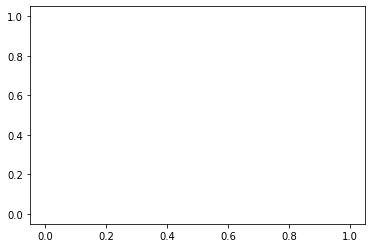

validation accuracy : 0.11071958456973294


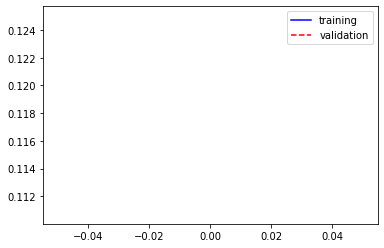

In [0]:
if __name__ == '__main__': #https://discuss.pytorch.org/t/brokenpipeerror-errno-32-broken-pipe-when-i-run-cifar10-tutorial-py/6224/4   
    torch.manual_seed(0)
    np.random.seed(0)
    torch.cuda.manual_seed(0)
    random.seed(0)
    
    criteria = torch.nn.CrossEntropyLoss()
    net = Load_model()
    train_loader, val_loader =Load_data()
    net=net.cuda()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60], gamma=0.1)
    net = train(net, train_loader, val_loader, criteria, optimizer, epochs, scheduler)
    #test_loader=torch.utils.data.DataLoader(test_loader,batch_size=128)
    #test_accuracy = test(net, test_loader)
    #print('Test Accuracy: {}'.format(test_accuracy))       
